50 resources tradeoffs model

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from joblib import Parallel, delayed
import glob
import time
from tqdm import tqdm
import os
import json
from lvm_prediction import predict
import pingouin as pg
from gradientDescent import ztheta

## Check alpha beta std matching

In [2]:
def calc_alpha_beta_stats(data):
    entropy = sp.stats.entropy(data.T)
    mean_alpha = np.mean(entropy)
    std_alpha = np.std(entropy)

    js_list = []
    for i in range(data.shape[0]):
        for j in range(i+1, data.shape[0]):
            js_list.append(sp.spatial.distance.jensenshannon(data[i], data[j]))
    js_list = np.array(js_list)

    mean_beta = np.mean(js_list)
    std_beta = np.std(js_list)
    
    return mean_alpha, std_alpha, mean_beta, std_beta

In [ ]:
from sklearn.mixture import GaussianMixture
def find_optimal_gaussians(X, max_components=10, plot=False, verbose=False):
    """
    Finds the optimal number of Gaussian components for a dataset using the Bayesian Information Criterion (BIC).

    Args:
        X (np.ndarray): The input data array, where rows are samples and columns are features.
        max_components (int): The maximum number of components to test.

    Returns:
        int: The optimal number of Gaussian components.
    """
    if not isinstance(X, np.ndarray) or X.ndim != 2:
        raise ValueError("Input data X must be a 2D NumPy array.")
    
    if X.shape[0] < max_components:
         print(f"Warning: Number of samples ({X.shape[0]}) is less than max_components ({max_components}). "
               f"It's recommended to have more samples than components.")


    bic_scores = []
    n_components_range = range(1, max_components + 1)

    if verbose:
        print(f"Testing number of components from 1 to {max_components}...")

    for n_components in n_components_range:
        # Initialize and fit the Gaussian Mixture Model
        gmm = GaussianMixture(n_components=n_components, 
                              random_state=42, 
                              covariance_type='full')
        gmm.fit(X)
        
        # Calculate and store the BIC score
        bic_scores.append(gmm.bic(X))
        if verbose:
            print(f"  Components: {n_components}, BIC: {bic_scores[-1]:.4f}")

    # Find the number of components that corresponds to the lowest BIC
    optimal_n_components = np.argmin(bic_scores) + 1 # Add 1 because range starts from 1
    
    if plot:
        # Plotting the BIC scores for visualization
        plt.figure(figsize=(10, 6))
        plt.plot(n_components_range, bic_scores, marker='o', linestyle='-')
        plt.title('BIC Scores for Different Numbers of Gaussian Components')
        plt.xlabel('Number of Components')
        plt.ylabel('Bayesian Information Criterion (BIC)')
        plt.xticks(n_components_range)
        # Highlight the minimum BIC score
        plt.axvline(optimal_n_components, color='r', linestyle='--', 
                    label=f'Optimal Components: {optimal_n_components}')
        plt.legend()
        plt.grid(True)
        plt.show()

    return optimal_n_components

In [13]:
ETA = 0.01
NUM_STEPS = 10000
NUM_LATENTS = 10

files = glob.glob('/home/ks2823/Microbiomap/in_silico_replicates_v5/*.json')

for file in files[2:]:
    num_niches = int(file.split('_')[-1].split('.')[0])
    data_list = []
    if os.path.exists(file):
        with open(file, 'r') as f:
            for line in f:
                item = json.loads(line)
                data_list.append(item)

    prediction_error = []
    for dataset in tqdm(data_list):
        if dataset['best_dist'] > 0.3:
            continue
        
        project_id = dataset['label']
        data = pd.read_csv(f'post_process_projects/{project_id}.csv', index_col=0).values[:200, :]
        
        ztheta_obj = ztheta(data, eta=ETA, num_steps=NUM_STEPS, num_latents=NUM_LATENTS, plot=False)
        
        if ~ztheta_obj.converged:
            continue
        
        num_gauss = find_optimal_gaussians(ztheta_obj.z)
        prediction_error.append(100*np.abs(num_gauss - num_niches)/num_niches)
    
    prediction_error = np.array(prediction_error)
    percent_predicted = np.sum(prediction_error==0)/len(prediction_error)
    print('No. niches:', num_niches, 'Percent predicted:' , percent_predicted, 'Median prediction error', np.median(prediction_error))
    # break
    

100%|██████████| 50/50 [00:59<00:00,  1.19s/it]


No. niches: 2 Percent predicted: 0.02857142857142857 Median prediction error 50.0


100%|██████████| 50/50 [01:03<00:00,  1.27s/it]


No. niches: 3 Percent predicted: 0.02702702702702703 Median prediction error 66.66666666666667


100%|██████████| 50/50 [01:09<00:00,  1.39s/it]


No. niches: 4 Percent predicted: 0.023809523809523808 Median prediction error 75.0


100%|██████████| 50/50 [01:02<00:00,  1.24s/it]


No. niches: 5 Percent predicted: 0.0 Median prediction error 80.0


100%|██████████| 50/50 [01:03<00:00,  1.27s/it]


No. niches: 6 Percent predicted: 0.027777777777777776 Median prediction error 83.33333333333333


100%|██████████| 50/50 [01:07<00:00,  1.35s/it]


No. niches: 7 Percent predicted: 0.02564102564102564 Median prediction error 85.71428571428571


100%|██████████| 50/50 [01:08<00:00,  1.38s/it]


No. niches: 8 Percent predicted: 0.047619047619047616 Median prediction error 87.5


100%|██████████| 50/50 [01:06<00:00,  1.33s/it]

No. niches: 9 Percent predicted: 0.05263157894736842 Median prediction error 88.88888888888889


Num niches: 1


100%|██████████| 50/50 [00:22<00:00,  2.26it/s]


Max number of species: 119


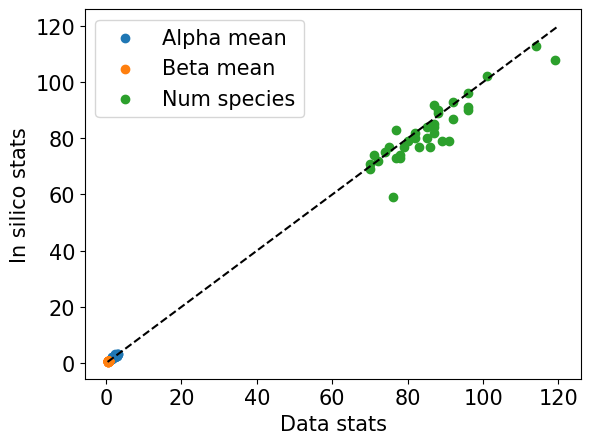

Num niches: 10


100%|██████████| 50/50 [00:22<00:00,  2.20it/s]

Max number of species: 119


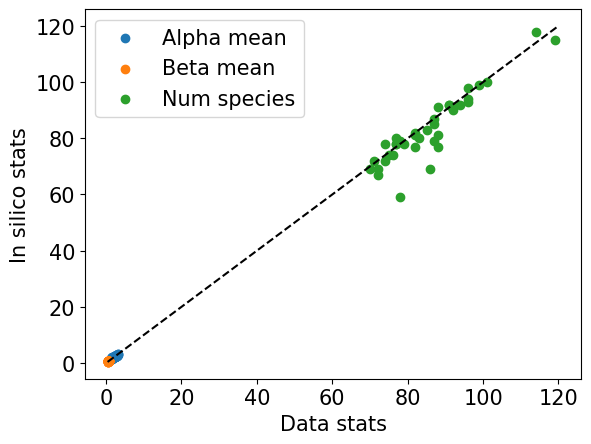

Num niches: 2


100%|██████████| 50/50 [00:21<00:00,  2.33it/s]

Max number of species: 114


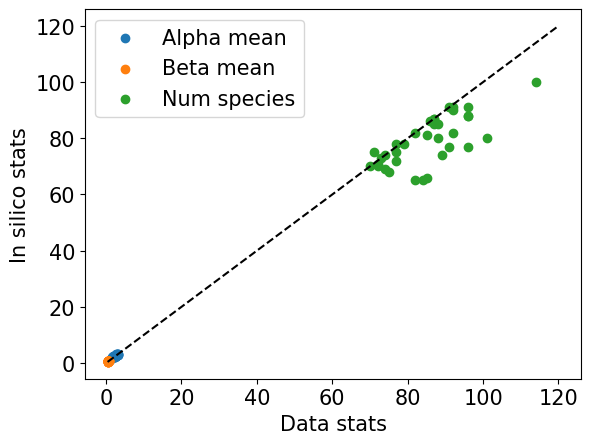

Num niches: 3


100%|██████████| 50/50 [00:23<00:00,  2.15it/s]

Max number of species: 119


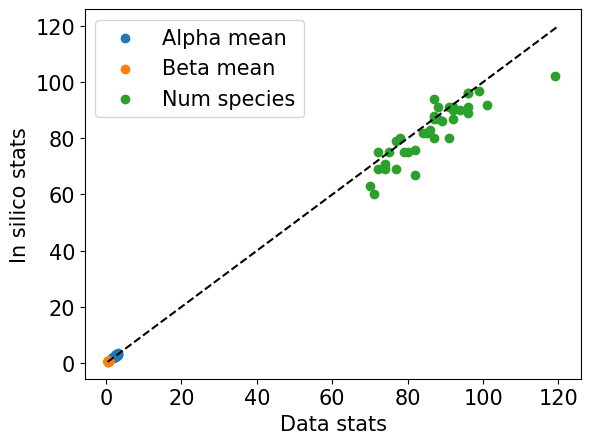

Num niches: 4


100%|██████████| 50/50 [00:25<00:00,  1.95it/s]


Max number of species: 119


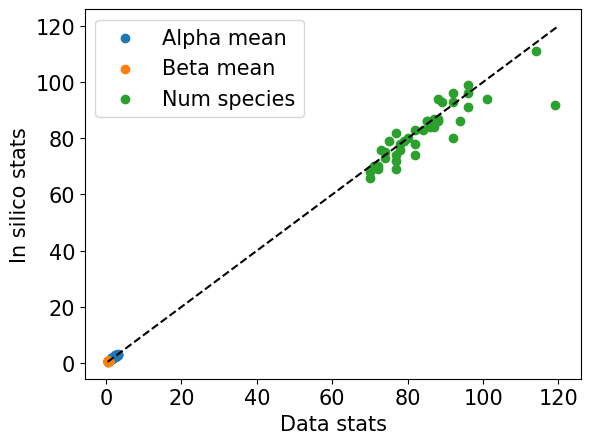

Num niches: 5


100%|██████████| 50/50 [00:24<00:00,  2.06it/s]

Max number of species: 119


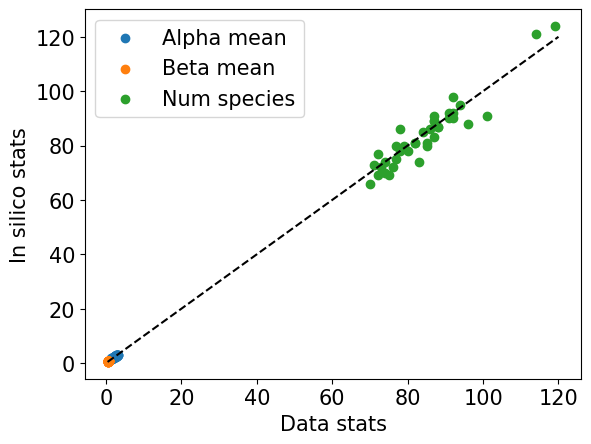

Num niches: 6


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]

Max number of species: 119


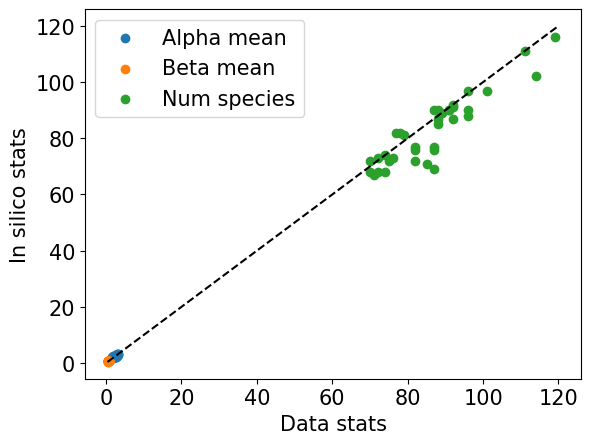

Num niches: 7


100%|██████████| 50/50 [00:24<00:00,  2.05it/s]

Max number of species: 119


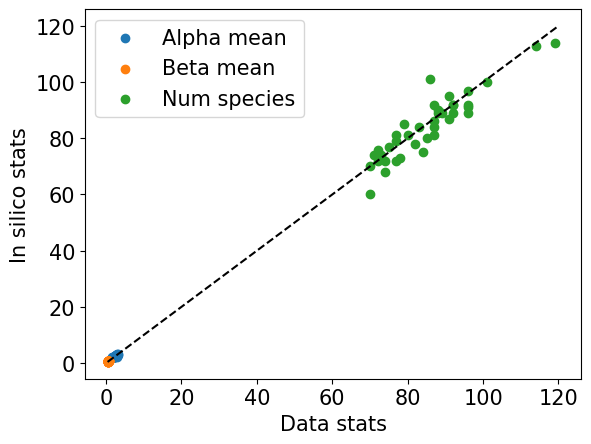

Num niches: 8


100%|██████████| 50/50 [00:26<00:00,  1.92it/s]

Max number of species: 119


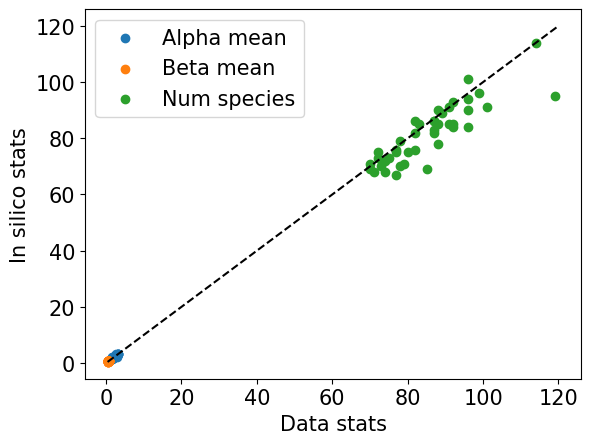

Num niches: 9


100%|██████████| 50/50 [00:23<00:00,  2.10it/s]

Max number of species: 114


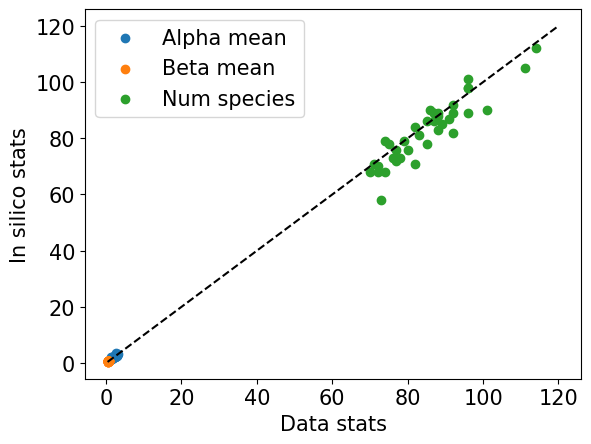

In [3]:
files = glob.glob('/home/ks2823/Microbiomap/in_silico_replicates_v5/*.json')
for file in files:
    in_silico_alpha_mean_list = []
    in_silico_alpha_std_list = []
    in_silico_beta_mean_list = []
    in_silico_beta_std_list = []
    num_species_list = []
    in_silico_num_species_list = []

    alpha_mean_list = []
    alpha_std_list = []
    beta_mean_list = []
    beta_std_list = []
    
    num_niches = int(file.split('_')[-1].split('.')[0])
    print("Num niches:", num_niches)

    data_list = []
    if os.path.exists(file):
        with open(file, 'r') as f:
            for line in f:
                item = json.loads(line)
                data_list.append(item)
    
    best_dist_list = []    
    for dataset in tqdm(data_list):
        if dataset['best_dist'] > 0.3:
            continue
        
        project_id = dataset['label']
        data = pd.read_csv(f'post_process_projects/{project_id}.csv', index_col=0).values[:200, :]
        
        num_species = data.shape[1]
        
        abu = np.array(dataset['data'])
        metadata = np.array(dataset['metadata'])
        total_abu = np.sum(abu, axis=1)
        rel_abu = abu/total_abu[:, np.newaxis]

        mult_data = np.array([np.random.multinomial(10000, sample) for sample in rel_abu])
        rel_mult_data = mult_data/np.sum(mult_data, axis=1)[:, np.newaxis]

        mult_survival_idxs = np.mean(rel_mult_data, axis=0) >= 1e-3

        in_silico_data = rel_mult_data[:, mult_survival_idxs]
        in_silico_data /= np.sum(in_silico_data, axis=1)[:, np.newaxis]
        
        in_silico_num_species = in_silico_data.shape[1]
        
        alpha_mean, alpha_std, beta_mean, beta_std = calc_alpha_beta_stats(data)
        in_silico_alpha_mean, in_silico_alpha_std, in_silico_beta_mean, in_silico_beta_std = calc_alpha_beta_stats(in_silico_data)

        alpha_mean_list.append(alpha_mean)
        alpha_std_list.append(alpha_std)
        beta_mean_list.append(beta_mean)
        beta_std_list.append(beta_std)
        num_species_list.append(num_species)
        
        in_silico_alpha_mean_list.append(in_silico_alpha_mean)
        in_silico_alpha_std_list.append(in_silico_alpha_std)
        in_silico_beta_mean_list.append(in_silico_beta_mean)
        in_silico_beta_std_list.append(in_silico_beta_std)
        in_silico_num_species_list.append(in_silico_num_species)
        
    print(f'Max number of species: {np.max(num_species_list)}')
    plt.scatter(alpha_mean_list, in_silico_alpha_mean_list, label='Alpha mean')
    # plt.scatter(alpha_std_list, in_silico_alpha_std_list, label='Alpha std')
    plt.scatter(beta_mean_list, in_silico_beta_mean_list, label='Beta mean')
    # plt.scatter(beta_std_list, in_silico_beta_std_list, label='Beta std')
    plt.scatter(num_species_list, in_silico_num_species_list, label='Num species')
    plt.xlabel('Data stats')
    plt.legend()
    plt.ylabel('In silico stats')
    # plt.xscale('log')
    # plt.yscale('log')
    plt.plot(np.linspace(0.4, 120, 100), np.linspace(0.4, 120, 100), color='black', linestyle='--')
    plt.show()
    

## Initial calculations

In [2]:
def calc_taylor_slope(data):
    # Placeholder for actual slope calculation logic
    # Assuming data to be a 2D array-like structure
    means = data.mean(axis=0)
    variances = data.var(axis=0)
    slope = np.polyfit(np.log(means), np.log(variances), 1)[0]
    return slope

def calc_alpha(data):
    return sp.stats.entropy(data, axis=1).mean()

def fit_exp(data):
    data = data[:5]
    data = data/data[0]
    model = LinearRegression()
    try:
        model.fit(np.arange(len(data)).reshape(-1, 1), np.log(data))
    except:
        return np.nan
    exponent = -model.coef_[0]
    return exponent

def participation_ratio(eigenvalues):
    return (np.sum(eigenvalues) ** 2) / np.sum(eigenvalues ** 2)

def get_shuffled(data, normalization=True):
    permuted_data = np.array([np.random.permutation(x) for x in data.T]).T
    if normalization:
        permuted_data /= np.sum(permuted_data, axis=1)[:, np.newaxis]
    return permuted_data

def calc_env_dim(met):
    met[met<=0] = 0.1*np.min(met[met>0])
    log_met = np.log(met) 
    
    met = met - np.mean(met, axis=0)[np.newaxis, :]
    met = met[:, ~(np.std(met, axis=0)==0)]
    met_std = np.std(met, axis=0)
    assert np.all(met_std!=0), "Met is not filtered properly"
       
    log_met = log_met - np.mean(log_met, axis=0)[np.newaxis, :]
    log_met = log_met[:, ~(np.std(log_met, axis=0)==0)]
    log_met_std = np.std(log_met, axis=0)
    assert np.all(log_met_std!=0), "Log-Met is not filtered properly"
    
    met = met/met_std[np.newaxis, :]
    log_met = log_met/log_met_std[np.newaxis, :]
    
    met_shuffled = get_shuffled(met, normalization=False)
    log_met_shuffled = get_shuffled(log_met, normalization=False)
    
    svd = np.linalg.svd(met, compute_uv=False, full_matrices=False)
    svd_log = np.linalg.svd(log_met, compute_uv=False, full_matrices=False)
    svd_shuffled = np.linalg.svd(met_shuffled, compute_uv=False, full_matrices=False)
    svd_shuffled_log = np.linalg.svd(log_met_shuffled, compute_uv=False, full_matrices=False)
    
    
    env_dim = 1/fit_exp(svd)
    env_dim_log = 1/fit_exp(svd_log)
    env_pr = participation_ratio(svd)
    env_pr_log = participation_ratio(svd_log)
    env_shuffled_pr = participation_ratio(svd_shuffled)
    env_shuffled_pr_log = participation_ratio(svd_shuffled_log)
    env_pr_corrected = env_pr - env_shuffled_pr
    env_pr_log_corrected = env_pr_log - env_shuffled_pr_log
    
    return env_dim, env_dim_log, env_pr, env_pr_log, env_pr_corrected, env_pr_log_corrected

def calc_generalists(crm, mean_abu):
    # sparsity = np.sum(crm)/crm.size    
    # mean_num_resources = crm.shape[1]*sparsity
    # weighted_num_resources = np.dot(crm.sum(axis=1), mean_abu)
    # weighted_to_mean_ratio = weighted_num_resources/mean_num_resources
    
    # return weighted_to_mean_ratio
    return np.dot(mean_abu, crm.sum(axis=1))/np.mean(crm.sum(axis=1))  

In [4]:
files = glob.glob('/home/ks2823/Microbiomap/in_silico_replicates_v5/*.json')
for file in files:
    num_niches = int(file.split('_')[-1].split('.')[0])
    print("Num niches:", num_niches)

    data_list = []
    if os.path.exists(file):
        with open(file, 'r') as f:
            for line in f:
                item = json.loads(line)
                data_list.append(item)
    
    best_dist_list = []    
    for dataset in data_list:
        # print(dataset.keys())
        project_id = dataset['label']

        best_dist = dataset['best_dist']
        best_dist_list.append(best_dist)
    best_dist_list = np.array(best_dist_list)
    
    print(f'Max: {np.max(best_dist_list):.2f}, Mean: {np.mean(best_dist_list):.2f}, Min: {np.min(best_dist_list):.2f}, Percent under 0.3: {(np.sum(best_dist_list<0.3)/best_dist_list.size)}, No.of projects: {len(data_list)}\n')
        

Num niches: 1
Max: 0.72, Mean: 0.26, Min: 0.14, Percent under 0.3: 0.7, No.of projects: 50

Num niches: 10
Max: 0.67, Mean: 0.24, Min: 0.06, Percent under 0.3: 0.76, No.of projects: 50

Num niches: 2
Max: 0.84, Mean: 0.27, Min: 0.04, Percent under 0.3: 0.7, No.of projects: 50

Num niches: 3
Max: 0.73, Mean: 0.25, Min: 0.08, Percent under 0.3: 0.74, No.of projects: 50

Num niches: 4
Max: 0.43, Mean: 0.23, Min: 0.09, Percent under 0.3: 0.84, No.of projects: 50

Num niches: 5
Max: 0.51, Mean: 0.23, Min: 0.07, Percent under 0.3: 0.76, No.of projects: 50

Num niches: 6
Max: 0.60, Mean: 0.25, Min: 0.06, Percent under 0.3: 0.72, No.of projects: 50

Num niches: 7
Max: 1.10, Mean: 0.27, Min: 0.06, Percent under 0.3: 0.78, No.of projects: 50

Num niches: 8
Max: 1.35, Mean: 0.24, Min: 0.03, Percent under 0.3: 0.84, No.of projects: 50

Num niches: 9
Max: 0.57, Mean: 0.24, Min: 0.08, Percent under 0.3: 0.76, No.of projects: 50



In [3]:
in_silico_checkpoint_file = '/home/ks2823/Microbiomap/checkpoints/in_silico_v5.csv'
files = glob.glob('/home/ks2823/Microbiomap/in_silico_replicates_v5/*.json')

in_silico_df = pd.DataFrame() 

# try:
#     in_silico_df = pd.read_csv(in_silico_checkpoint_file, index_col=0)
# except FileNotFoundError:
#     print(f"Checkpoint file not found: {in_silico_checkpoint_file}. Starting with an empty DataFrame.")
# except Exception as e:
#     print(f"An error occurred while reading the checkpoint file: {e}")

for file in files:
    
    num_niches = int(file.split('_')[-1].split('.')[0])
    print("Num niches:", num_niches)

    processed_projects = []
    if not in_silico_df.empty:
        processed_projects = list(in_silico_df[in_silico_df['num_niches'] == num_niches]['label'])
        print(f'Already processed {len(processed_projects)}')

    data_list = []
    if os.path.exists(file):
        with open(file, 'r') as f:
            for line in f:
                item = json.loads(line)
                data_list.append(item)

    for dataset in tqdm(data_list):
        # print(dataset.keys())
        if dataset['best_dist'] > 0.3:
            continue
        project_id = dataset['label']
        
        if project_id in processed_projects:
            # print(f'Skipping {project_id}')
            continue

        abu = np.array(dataset['data'])
        metadata = np.array(dataset['metadata'])
        
        inflow = np.array(dataset['inflow'])
        total_abu = np.sum(abu, axis=1)
        rel_abu = abu/total_abu[:, np.newaxis]
        
        load_ratio = total_abu.mean()/inflow.mean()

        mult_data = np.array([np.random.multinomial(10000, sample) for sample in rel_abu])
        rel_mult_data = mult_data/np.sum(mult_data, axis=1)[:, np.newaxis]

        mult_survival_idxs = np.mean(rel_mult_data, axis=0) >= 1e-3

        preference_list = np.array(dataset['CRM'])[mult_survival_idxs, :]
        cosine_similarity = sp.spatial.distance.pdist(preference_list, 'cosine')
        preference_list[preference_list > 0] = 1

        data = rel_mult_data[:, mult_survival_idxs]
        data /= np.sum(data, axis=1)[:, np.newaxis]
        
        crm = np.array(dataset['CRM'])[mult_survival_idxs, :]
        non_zero_idxs = np.sum(crm, axis=0) > 0
        
        num_resources = non_zero_idxs.size
        
        crm = crm[:, non_zero_idxs]
        crm[crm>0] = 1
        
        crm_sparsity = np.mean(crm)
        mean_num_resources = np.mean(np.sum(crm, axis=1))
        
        taylor = calc_taylor_slope(data)
        alpha = calc_alpha(data)
        env_dim, env_dim_log, env_pr, env_pr_log, env_pr_corrected, env_pr_log_correced = calc_env_dim(inflow)
        
        generalists = calc_generalists(crm, data.mean(axis=0))

        output = {
            'label': project_id,
            'num_niches': num_niches,
            'mean_load' : total_abu.mean(),
            'var_load' : np.var(total_abu),
            'load_ratio': load_ratio,
            'mean_resources' : preference_list.sum(axis=1).mean(),
            'weighted_pref' : np.dot(data.mean(axis=0), preference_list.sum(axis=1)),
            'cosine_similarity': cosine_similarity.mean(),
            'taylor': taylor,
            'alpha': alpha,
            'EnvDim': env_dim,
            'EnvDimLog': env_dim_log,
            'EnvPr': env_pr,
            'EnvPrLog': env_pr_log, 
            'EnvPrCorr': env_pr_corrected,
            'EnvPrLogCorr': env_pr_log_correced,
            'best_dist': dataset['best_dist'],
            'num_resources': num_resources,
            'generalists': generalists,
            'crm_sparsity': crm_sparsity,
            'mean_num_resources': mean_num_resources,
        }
        
        in_silico_df = pd.concat([in_silico_df, pd.DataFrame([output])], ignore_index=True)
        in_silico_df.to_csv(in_silico_checkpoint_file)

Num niches: 1


100%|██████████| 50/50 [00:00<00:00, 52.78it/s]


Num niches: 10
Already processed 0


100%|██████████| 50/50 [00:01<00:00, 47.28it/s]


Num niches: 2
Already processed 0


100%|██████████| 50/50 [00:01<00:00, 41.08it/s]


Num niches: 3
Already processed 0


100%|██████████| 50/50 [00:01<00:00, 43.85it/s]


Num niches: 4
Already processed 0


100%|██████████| 50/50 [00:01<00:00, 43.72it/s]


Num niches: 5
Already processed 0


100%|██████████| 50/50 [00:01<00:00, 31.26it/s]


Num niches: 6
Already processed 0


100%|██████████| 50/50 [00:01<00:00, 38.09it/s]


Num niches: 7
Already processed 0


100%|██████████| 50/50 [00:01<00:00, 40.64it/s]


Num niches: 8
Already processed 0


100%|██████████| 50/50 [00:01<00:00, 29.08it/s]


Num niches: 9
Already processed 0


100%|██████████| 50/50 [00:01<00:00, 33.67it/s]


In [4]:
df_list = []

for i in tqdm(range(1, 11)):
    # Read the JSON files
    df_cg_i = pd.read_json(f'Data/in_silico_v5_results/in_silico_cg/cg_{i}.json', lines=True)
    df_cg_null_i = pd.read_json(f'Data/in_silico_v5_results/in_silico_cg_null/cg_null_{i}.json', lines=True)
    df_comp_i = pd.read_json(f'Data/in_silico_v5_results/in_silico_comp/comp_{i}.json', lines=True)
    # df_bin_pred_i = pd.read_json(f'Data/in_silico_v4_results/in_silico_bin_pred/in_silico_bin_pred_{i}.json', lines=True)
    # df_cv = pd.read_json(f'Data/in_silico_v4_results/in_silico_cv_theta/cv_theta_{i}.json', lines=True)
    # df_cv = df_cv.drop(columns=['NumNiches'])
    df_final_i = pd.merge(df_comp_i, df_cg_i, on='label')
    df_final_i = pd.merge(df_final_i, df_cg_null_i)
    # df_final_i = pd.merge(df_final_i, df_bin_pred_i, on='label')
    # df_final_i = pd.merge(df_final_i, df_cv, on='label')
    
    df_final_i['num_niches'] = i
    
    df_list.append(df_final_i)

100%|██████████| 10/10 [00:00<00:00, 55.16it/s]


In [6]:
df = pd.concat(df_list)
df['NicheDim'] = 1/df['exp_cg']
df['NicheDim_null'] = 1/df['exp_cg_null']
df['comp'] = df['comp'].apply(lambda x: np.sum(x))
df.head()

,label,comp,exp_cg,exp_cg_null,num_niches,NicheDim,NicheDim_null
0,PRJNA430990,6.327069,0.102889,0.088204,1,9.719252,11.337355
1,PRJEB27564,8.815534,0.106731,0.069391,1,9.369364,14.411078
2,PRJEB36316,10.966619,0.092966,0.064189,1,10.756595,15.578895
3,PRJNA625750,6.246748,0.134475,0.124311,1,7.436340,8.044348
4,PRJNA530790,3.931716,0.110720,0.090559,1,9.031829,11.042499


In [7]:
x = 1/df.dropna()['exp_cg']
y = df.dropna()['comp']

spearman, pval = sp.stats.spearmanr(x, y)
print(spearman, pval)

-0.22963781455125817 2.0855852153745047e-07


In [7]:
in_silico_df = pd.merge(in_silico_df, df, on=['num_niches', 'label'], how='inner')
print(len(in_silico_df))

380


In [8]:
in_silico_df.to_csv(in_silico_checkpoint_file)

## Load from checkpoint

In [8]:
in_silico_checkpoint_file = '/home/ks2823/Microbiomap/checkpoints/in_silico_v5.csv'
in_silico_df = pd.read_csv(in_silico_checkpoint_file, index_col=0)
print(in_silico_df.head())
print(len(in_silico_df))

         label  num_niches  mean_load  var_load  load_ratio  mean_resources  \
0   PRJEB27564           1   4.184890  0.236736    1.705006        2.988764   
1  PRJNA625750           1   2.157081  0.228950    0.918600        2.576923   
2  PRJNA530790           1   2.997588  0.111297    1.188811        2.764706   
3  PRJNA674420           1   6.156312  0.382769    2.541166        3.433735   
4  PRJNA685389           1   3.091196  0.403170    1.189287        3.305263   

   weighted_pref  cosine_similarity    taylor     alpha  ...   EnvPrLog  \
0       2.338811           0.927478  1.187523  3.306112  ...  43.508737   
1       2.075025           0.933749  1.162099  2.485557  ...  43.449421   
2       2.577292           0.932503  1.129079  2.883249  ...  43.583219   
3       3.192635           0.918658  1.098390  2.976055  ...  43.390499   
4       2.937356           0.921807  1.115679  2.567224  ...  43.646307   

   EnvPrCorr  EnvPrLogCorr  best_dist  num_resources  generalists  \
0  -0

In [24]:
in_silico_df['scaled_weighted_pref'] = in_silico_df['weighted_pref']/(in_silico_df['mean_resources'])

### Check Taylor

In [65]:
is_taylor_df = in_silico_df[['label', 'num_niches', 'taylor', 'best_dist']]
combined_df = pd.read_csv('/home/ks2823/Microbiomap/checkpoints/combined_df.csv', index_col=0)
mb_taylor_df = combined_df[['project', 'Taylor_slope']]
print(mb_taylor_df.head())
print(is_taylor_df.head())

      project  Taylor_slope
0  PRJDB10485      1.668182
1  PRJDB10528      1.496769
2  PRJDB10612      1.438723
3  PRJDB11845      1.437620
4  PRJDB11894      1.569955
         label  num_niches    taylor  best_dist
0  PRJNA430990           1  1.044103   0.442956
1   PRJEB27564           1  1.183866   0.154522
2   PRJEB36316           1  1.262159   0.477032
3  PRJNA625750           1  1.159184   0.235041
4  PRJNA530790           1  1.120265   0.298350


In [31]:
is_taylor_df['Taylor_slope'] = is_taylor_df['label'].apply(lambda x: mb_taylor_df[mb_taylor_df['project']==x]['Taylor_slope'].values[0])
is_taylor_df.head()

/tmp/tmp.DBf4P9GpZL/ipykernel_912148/1524441510.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  is_taylor_df['Taylor_slope'] = is_taylor_df['label'].apply(lambda x: mb_taylor_df[mb_taylor_df['project']==x]['Taylor_slope'].values[0])


,label,num_niches,taylor,best_dist,Taylor_slope
0,PRJNA430990,1,1.027385,0.442956,1.593494
1,PRJEB27564,1,1.187304,0.154522,1.481632
2,PRJEB36316,1,1.210782,0.477032,1.438081
3,PRJNA625750,1,1.160822,0.235041,1.708729
4,PRJNA530790,1,1.124435,0.298350,1.456192


In [38]:
x = is_taylor_df['Taylor_slope']
y = is_taylor_df['taylor']
c = is_taylor_df['num_niches']
dist = is_taylor_df['best_dist']

mask = ~np.isnan(x) & (dist < 0.45)

x = x[mask]
y = y[mask]
c = c[mask]

In [39]:
spearman, pval = sp.stats.spearmanr(x, y)
print(f'Spearman R: {spearman:.3f}, P-value: {pval}')

Spearman R: 0.267, P-value: 1.6853487453567957e-08


Spearman R: 0.132, P-value: 0.3977629353011354
Spearman R: 0.258, P-value: 0.09514012944272428
Spearman R: 0.200, P-value: 0.2050917728483448
Spearman R: 0.244, P-value: 0.1107062625794611
Spearman R: 0.410, P-value: 0.005154747612112401
Spearman R: 0.298, P-value: 0.04937177703922021
Spearman R: 0.225, P-value: 0.15283950507131763
Spearman R: 0.242, P-value: 0.11806372303309054
Spearman R: 0.400, P-value: 0.007206561457517727
Spearman R: 0.308, P-value: 0.04227768285356419


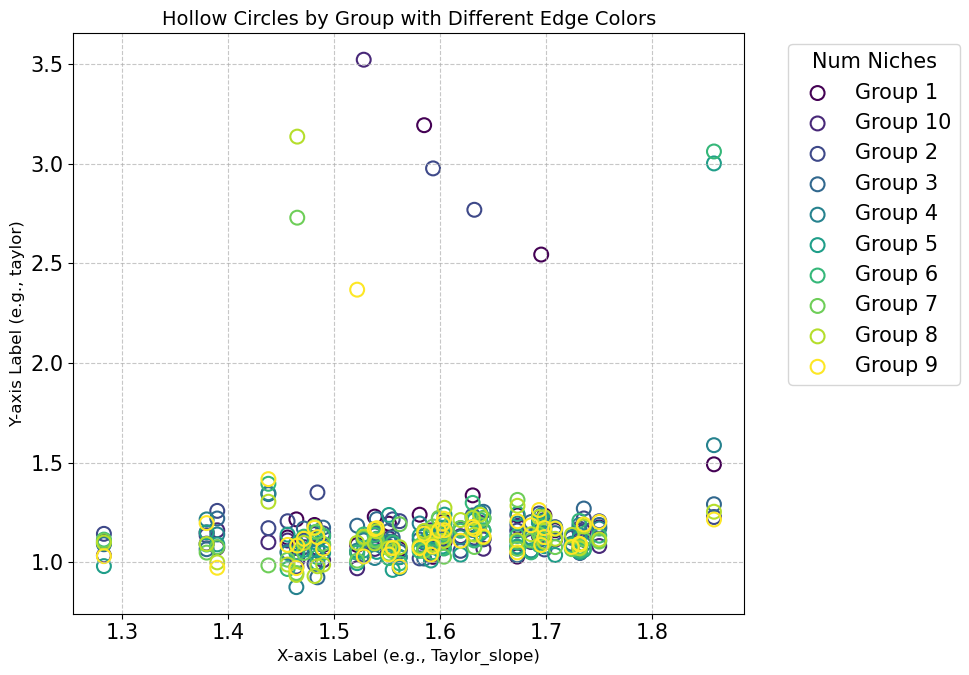

In [40]:
# This step is optional if x, y, c are already aligned Series/arrays
plot_data = pd.DataFrame({'x': x, 'y': y, 'group': c})

# Get unique groups from 'c'
unique_groups = plot_data['group'].unique()

# Define a colormap or a list of colors
# Using a colormap ensures a good range of distinct colors
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_groups)))

# Create the plot
plt.figure(figsize=(10, 7)) # Adjust figure size for better readability

# Loop through each unique group and plot them with different colors
for i, group_value in enumerate(unique_groups):
    # if i != 1:
    #     continue
    # Select data points belonging to the current group
    group_data = plot_data[plot_data['group'] == group_value]

    # Plot hollow circles for the current group
    plt.scatter(
        group_data['x'],
        group_data['y'],
        marker='o',              # Circle marker
        facecolors='none',       # No fill inside the circle
        edgecolors=colors[i],    # Color the edge based on the group
        label=f'Group {group_value}', # Label for the legend
        s=100,                   # Size of the markers
        linewidth=1.5            # Thickness of the circle outline
    )

    spearman, pval = sp.stats.spearmanr(group_data['x'], group_data['y'])
    print(f'Spearman R: {spearman:.3f}, P-value: {pval}')
# Add plot enhancements for clarity
plt.xlabel('X-axis Label (e.g., Taylor_slope)', fontsize=12)
plt.ylabel('Y-axis Label (e.g., taylor)', fontsize=12)
plt.title('Hollow Circles by Group with Different Edge Colors', fontsize=14)
plt.legend(title='Num Niches', bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside for space
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout() # Adjust layout to prevent labels/legend from overlapping
# plt.ylim(0.8, 1.5)
# Display the plot
plt.show()

### Plot stuff

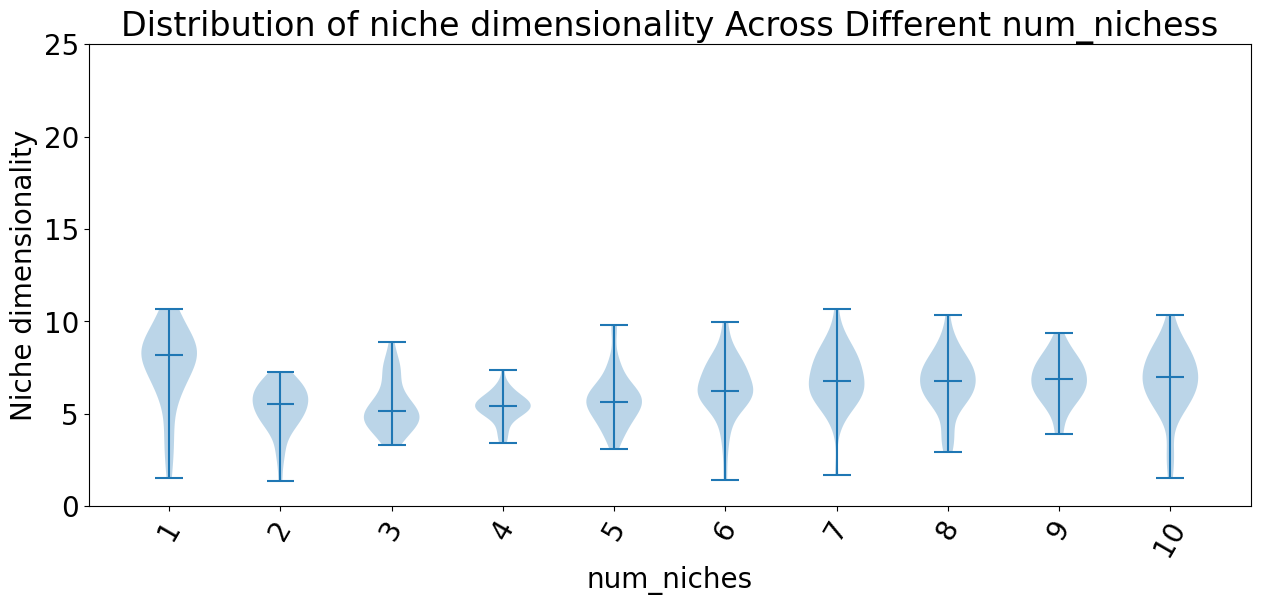

In [25]:
# Group exp_cg values by unique num_nichess
num_nichess = np.arange(1,11,1)
data = [in_silico_df[in_silico_df['num_niches'] == num_niches]['NicheDim'].values for num_niches in num_nichess]

# Create the violin plot
fig, ax = plt.subplots(figsize=(15, 6))
ax.violinplot(data, positions=np.arange(len(num_nichess)), showmedians=True, showextrema=True)

# Customize the plot
ax.set_xticks(np.arange(len(num_nichess)))
ax.set_xticklabels(num_nichess, rotation=60)  # Rotate labels for better readability
ax.set_xlabel("num_niches")
ax.set_ylabel("Niche dimensionality")
ax.set_title("Distribution of niche dimensionality Across Different num_nichess")
plt.ylim([0, 25])
plt.show()

In [26]:
def plot_helper(x, y, c=None, x_label=None, y_label=None, title=None):
    plt.rcParams.update({'font.size': 20})
    
    spearman, pval = sp.stats.spearmanr(x, y)
    print(f'Spearman R: {spearman}, P-value: {pval}')

    # Fit a straight line
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(x, y)

    # Create the line data
    line_x = np.linspace(min(x), max(x), 100)
    line_y = slope * line_x + intercept

    # Plot the line
    plt.figure(figsize=(7, 6))
    plt.plot(line_x, line_y, color='red', label=f'R: {spearman:.2f}', linestyle='--')

    if c is None:
        plt.scatter(x, y, color='black')
    else:
        plt.scatter(x, y, c=c)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

In [27]:
col_label_dict = {
    ### Dimensionality metrics
    # 'pr_corrected': 'Participation Ratio (corrected)',
    'NicheDim': 'Niche Dimensionality',
    'EnvDim': 'Environmental Dimensionality',
    # 'se_corrected': 'Spectrum Entropy (corrected)',
    'EnvDimLog': 'Environmental Dimensionality (Log)',
    'EnvPr': 'Envirnmental Complexity',
    'EnvPrLog': 'Envirnmental (Log) Complexity',
    'EnvPrCorr': 'Envirnmental Complexity (Corrected)',
    'EnvPrLogCorr': 'Envirnmental (Log) Complexity (Corrected)',
    
    
    ### Diversity metrics    
    # 'alpha': 'Shannon Entropy',
    # 'beta': 'Jensen-Shannon Divergence',
    
    ### Niche overlap metrics
    # 'theta_comp': 'Theta overlap',
    # 'theta_comp_corrected':'Theta overlap (corrected)',
    # 'comp': 'Niche Overlap',
    
    ### Generalists metrics
    
    # 'theta_generalists_pr': 'Theta Generalists PR',
    # 'theta_generalists_corrected': 'Theta Generalists (corrected)',
    # 'scaled_weighted_pref': 'Generalist ratio',
    # 'generalists': 'Generalists',
    
    ### Predictability metrics
    
    # 'binary_in_performance': 'Self predictability (in-sample)',
    # 'binary_out_performance': 'Self predictability (out-sample)',
    
    ### Others
    # 'mean_load': 'Load (mean)',
    # 'var_load': 'Load (variance)',
    # 'taylor': 'Taylor\'s Slope',
    # 'load_ratio': 'Normalized Load',
    # 'num_resources': 'No. of resources',
    }

Spearman R: 0.030829899056171783, P-value: 0.7061375676349556


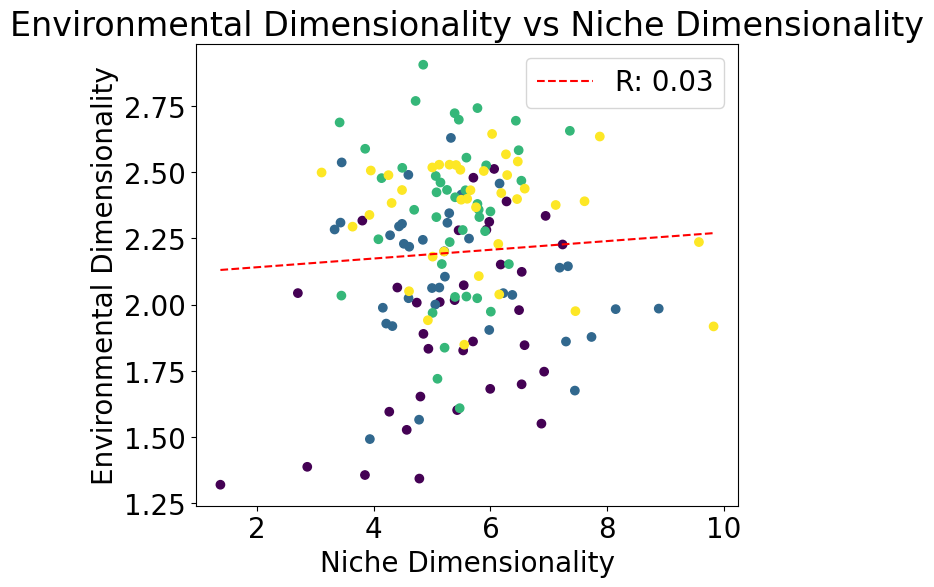

Spearman R: 0.1981629180079142, P-value: 0.014394360564016297


<Figure size 640x480 with 0 Axes>

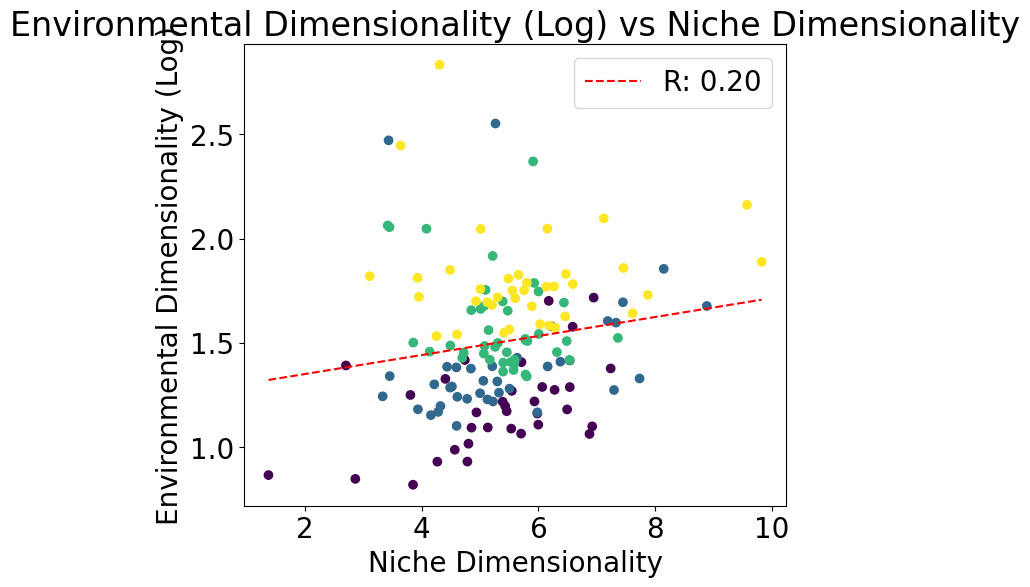

Spearman R: -0.08801317668928847, P-value: 0.28092853524013606


<Figure size 640x480 with 0 Axes>

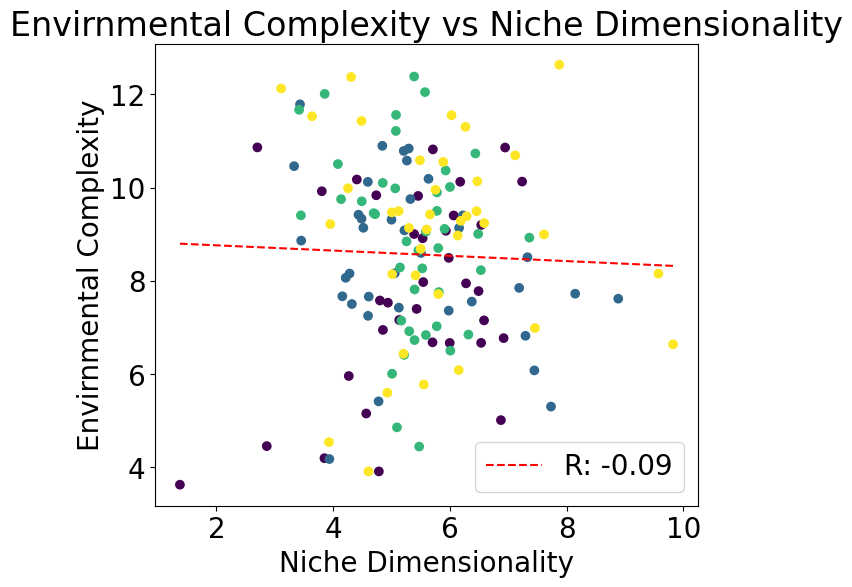

Spearman R: 0.295245320156644, P-value: 0.00022193345812952838


<Figure size 640x480 with 0 Axes>

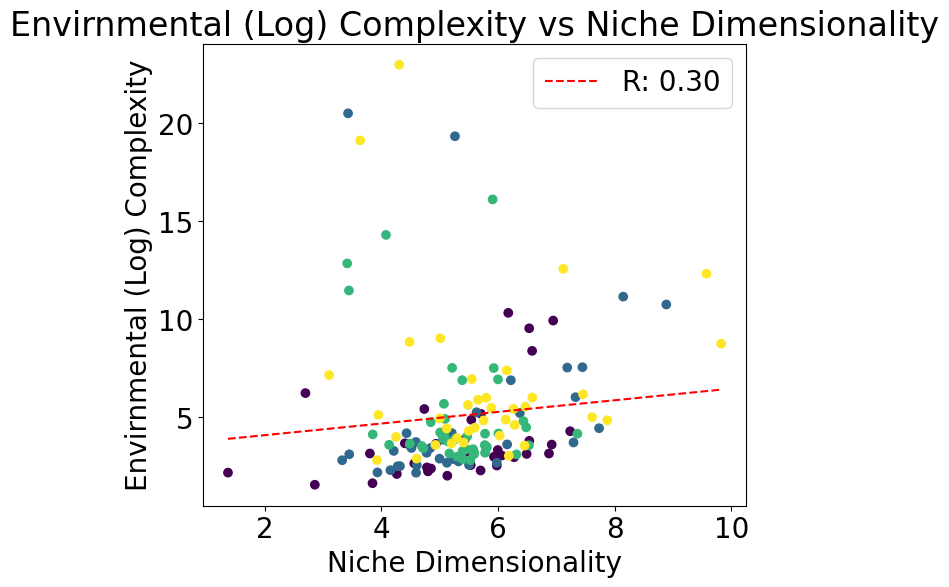

Spearman R: 0.4830814863414867, P-value: 2.912397251915868e-10


<Figure size 640x480 with 0 Axes>

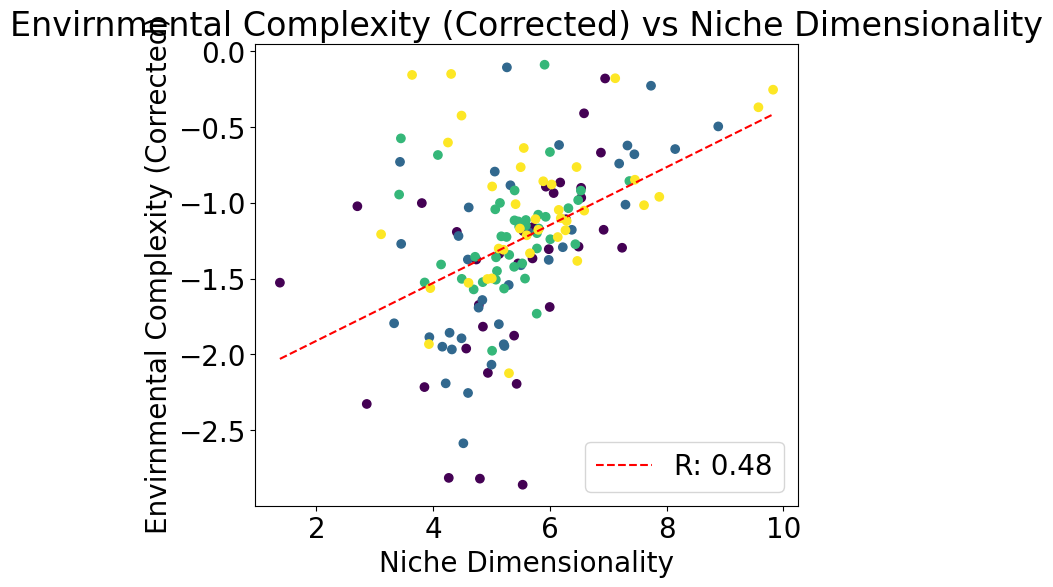

Spearman R: -0.0664062766968063, P-value: 0.41630356204180097


<Figure size 640x480 with 0 Axes>

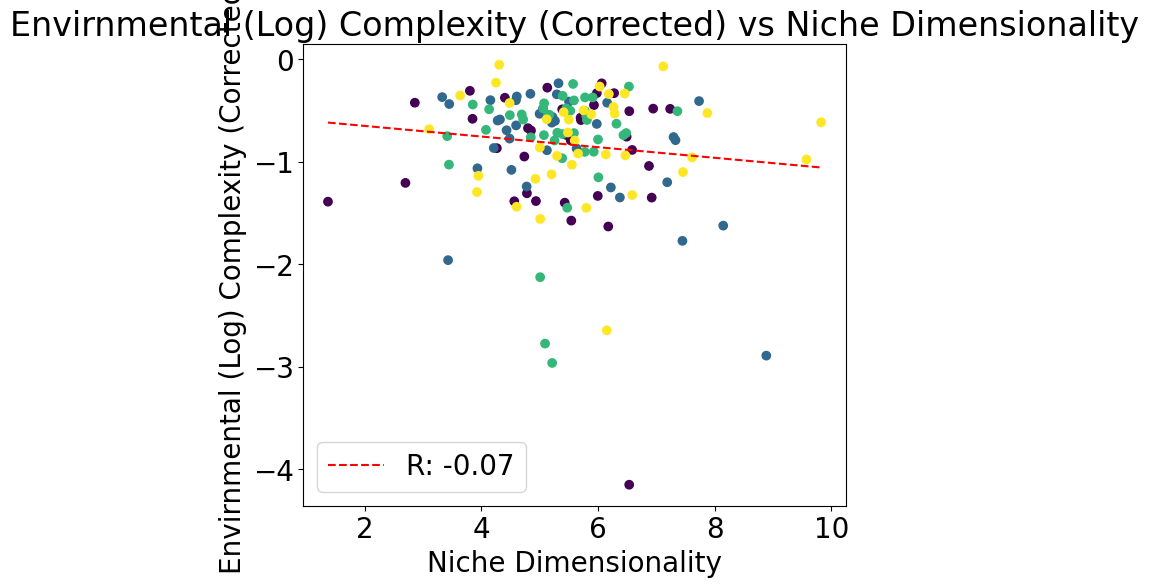

<Figure size 640x480 with 0 Axes>

In [28]:
from itertools import combinations

# assuming combined_df and col_label_dict are already defined, and plot_helper is in scope

for x_col, y_col in combinations(col_label_dict.keys(), 2):
    if x_col != 'NicheDim':
        continue
    
    x = in_silico_df[x_col]
    y = in_silico_df[y_col]
    c = in_silico_df['num_niches']
    
    mask = (c > 1) & (c < 6)
    
    x = x[mask]
    y = y[mask]
    c = c[mask]
    
    x_label = col_label_dict[x_col]
    y_label = col_label_dict[y_col]
    title   = f"{y_label} vs {x_label}"
    
    plot_helper(
        x, y,c=c,
        x_label=x_label,
        y_label=y_label,
        title=title
    )
    plt.savefig(f'/home/ks2823/Microbiomap/Data/in_silico_v5_results/plots/IS_{x_col}_{y_col}.pdf', format='pdf')